# Locker
By: Fredrik Sy
Date: 2019-12-29

Notebook to model locker for FMCW LIDAR

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Notes

- the start point in where you are along the locker path when doing a chirp is deterministic and is based on both the central frequency,locker delay and chirp rate. it's  - f_c * tau + 0.5*chirp_rate*tau

## Controls

In [2]:
dt=1 #[ns]
df = 1 #[GHz]
N_t =2000

tau = 5 #[ns]

f_c = 193600.225 #center frequency

offset=np.pi/2


sawtooth_period = 500 #[ns]
perc_pkpk = 5; # in %
alpha = 5/100/tau/sawtooth_period*2 #chirp rate GHz/ns


s1=0.5 # split ratio in first mixer
s2=0.5 # second mixer

time_axis_str='time[ns]'

## Signal Input
The signal is given by:
$$E_{\text{in}} = E_{\text{0}}$$ which is just a constant. 

Text(0, 0.5, 'Normalized Power')

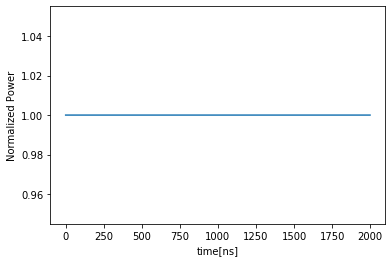

In [3]:
E_in=np.ones(N_t)
time = np.arange(0,N_t*dt,dt)
plt.plot(time,E_in)
plt.xlabel(time_axis_str)
plt.ylabel('Normalized Power')

## Chirp Laser
The signal then has to be chirped which we write as phase term

Text(0, 0.5, 'phase freq chirp contribution[radians]')

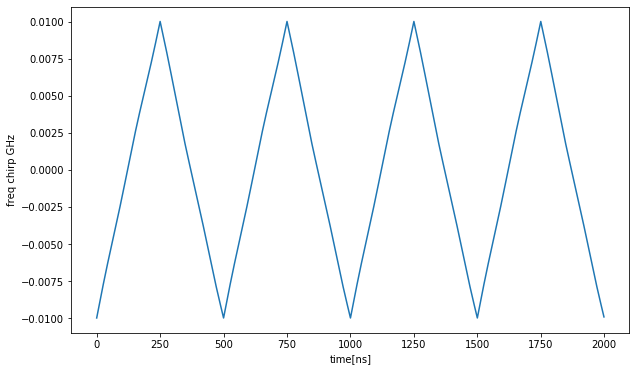

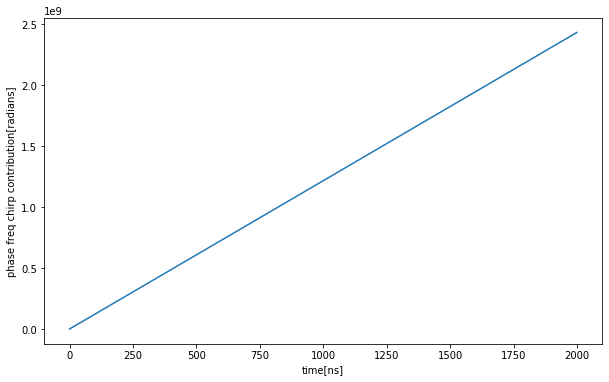

In [4]:
sawtooth=signal.sawtooth(t=time*2*np.pi/sawtooth_period,width=0.5) #Normalized
f_saw=sawtooth*(alpha*sawtooth_period/2) # GHz

scaling =1e0
# nonlinear frequency term
f_nl =  scaling*(3e-4*np.sin(2*np.pi/sawtooth_period*time)+1e-5*np.cos(2*2*np.pi/sawtooth_period*time)+1e-4*np.sin(4*2*np.pi/sawtooth_period*time))

f_chirp=f_saw+f_nl

p_fc= 2*np.pi*f_c*time
p_chirp = p_fc+ 2*np.pi*np.cumsum(f_chirp,axis=0)



f1,ax1=plt.subplots(figsize=(10,6))

ax1.plot(f_chirp)
ax1.set_xlabel(time_axis_str)
ax1.set_ylabel('freq chirp GHz')

f2,ax2=plt.subplots(figsize=(10,6))

ax2.plot(p_chirp)
ax2.set_xlabel(time_axis_str)
ax2.set_ylabel('phase freq chirp contribution[radians]')

## Chirped laser
The laser field is then represented as the real part of the complex field E_chirp = Ein * exp(p_chirp)

Text(0, 0.5, 'Real (E Field)')

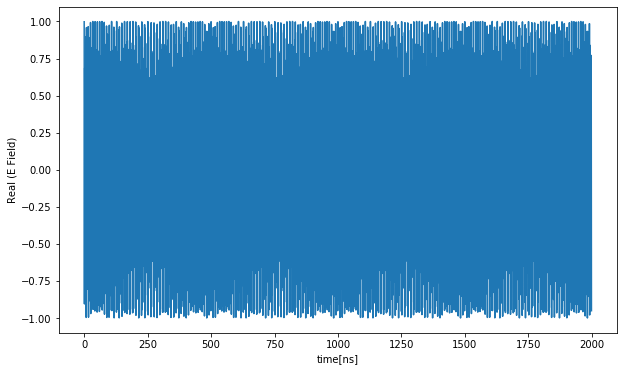

In [5]:
E_chirp=np.exp(1j*(p_fc+p_chirp))

f1,ax1=plt.subplots(figsize=(10,6))
ax1.plot(np.real(E_chirp))
ax1.set_xlabel(time_axis_str)
ax1.set_ylabel('Real (E Field)')

## 2x2 as a splitter + delay on second line

Text(0, 0.5, 'freq chirp GHz')

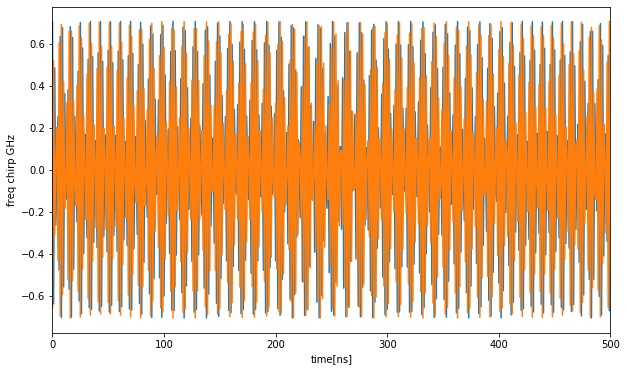

In [6]:
E_1 = E_chirp * np.sqrt(1-s1)
E_2 = E_chirp * 1j*np.sqrt(s1)

E_delay=np.roll(E_2,shift=-tau)# circular shift the the second E field

f1,ax1=plt.subplots(figsize=(10,6))
ax1.plot(np.real(E_1))
ax1.plot(np.real(E_delay))
ax1.set_xlim(0,500)
ax1.set_xlabel(time_axis_str)
ax1.set_ylabel('freq chirp GHz')


## 2x2 as Mixer, only using first to PD
calculate the abs^2 after
possibly use numba to make it faster in the future if needed

@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2
    
https://stackoverflow.com/questions/30437947/most-memory-efficient-way-to-compute-abs2-of-complex-numpy-ndarray



In [7]:
E_pd = np.sqrt(1-s2) * E_1  - 1j*np.sqrt(s2)*E_delay

(0, 1.1)

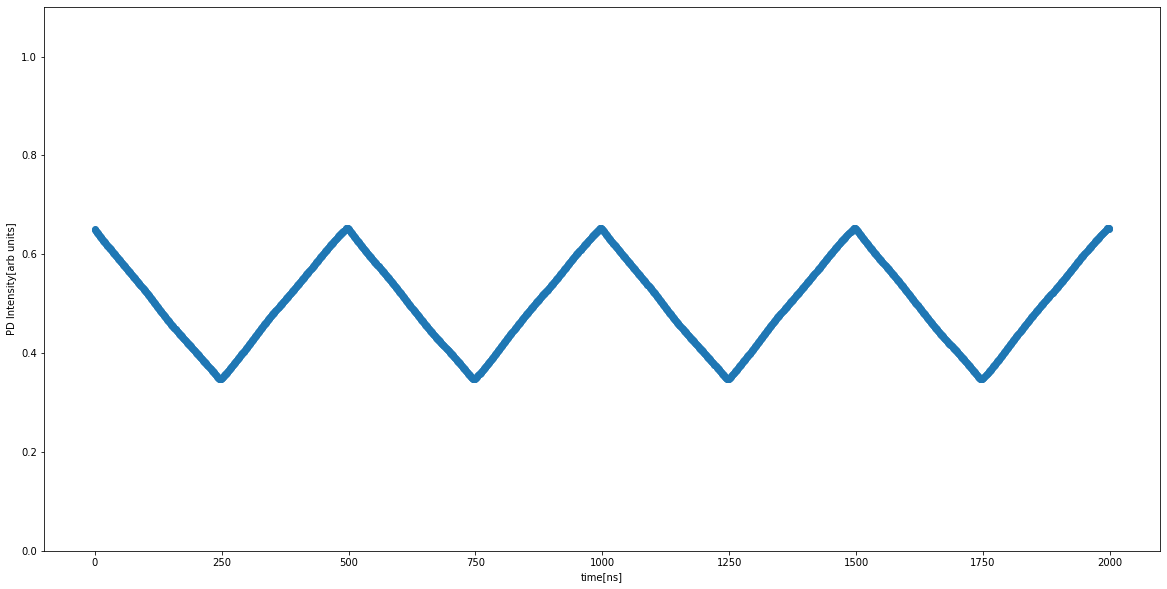

In [8]:
I_pd = np.abs(E_pd)
I_pd **= 2

f1,ax1=plt.subplots(figsize=(20,10))
ax1.scatter(time,I_pd)
ax1.set_xlabel(time_axis_str)
ax1.set_ylabel('PD Intensity[arb units]')
ax1.set_ylim(0,1.1)